# Comparison


In [1]:
import pandas as pd
import numpy as np
import os
import pickle

pd.set_option("display.max_columns", None)

In [2]:
from scripts.params import get_params
from scripts.aux_functions import get_all_results_matching

params = get_params()

In [3]:
from scripts.epftoolbox_dm_gw import DM, plot_multivariate_DM_test, GW, plot_multivariate_GW_test

In [4]:
dataroute = params["dataroute"]
resultsroute = params["resultsroute"]
dumproute = params["dumproute"]
graphsroute = params["graphsroute"]

In [5]:
start_test = params["start_test"]
local_suffix = params["local_suffix"]

In [6]:
name = f'finaldf_test_{params["tablename"]}.pickle'
filename = os.path.join(dataroute, name)
with open(filename, "rb") as handle:
    df_test = pickle.load(handle)
    
df_test.index=pd.to_datetime(df_test.index.copy())

In [8]:
all_forecasts = get_all_results_matching(params["resultsroute"], ["forecast"])
all_residuals = get_all_results_matching(params["resultsroute"], ["residual"])

{'GARCH_BR_^BVSP_aic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\GARCH_BR_^BVSP_aic_best_forecasts.pickle', 'GARCH_BR_^BVSP_bic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\GARCH_BR_^BVSP_bic_best_forecasts.pickle', 'HMM_multiv_BR_^BVSP_aic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_multiv_BR_^BVSP_aic_best_forecasts.pickle', 'HMM_multiv_BR_^BVSP_bic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_multiv_BR_^BVSP_bic_best_forecasts.pickle', 'HMM_univ_BR_^BVSP_aic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_univ_BR_^BVSP_aic_best_forecasts.pickle', 'HMM_univ_BR_^BVSP_bic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_univ_BR_^BVSP_bic_best_forecasts.pickle', 'HMM_with_vol_BR_^BVSP_aic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_with_vol_BR_^BVSP_aic_best_forecasts.pickle', 'HMM_with_vol_BR_^BVSP_bic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_with_vol_BR_^BVSP_bic_best_forecasts.pickle', 'VAR_multiv_BR_^BVSP_aic_best_forecasts.pickle': '.

In [9]:
def get_only_log_rets(dict_with_dfs: dict, stock: str):
    if type(dict_with_dfs[stock]) == pd.Series:
        # univariate models are saved as series
        df = pd.DataFrame(dict_with_dfs[stock])

    else:
        try:
            # multivariate models are saved as dataframes
            df = pd.DataFrame(dict_with_dfs[stock][f"{stock}_log_rets"])
        except:  # TODO: SACAR ESTO! Es un chanchullo pq hay algunas que son guardadas como None
            pass
    return df

In [10]:
def create_df_from_results_dict(results_dict:dict, substring_to_replace:str):
    created_df = pd.DataFrame()

    for name, dir in results_dict.items():
        dict_with_dfs = pd.read_pickle(dir)
        print(name)

        for stock in dict_with_dfs.keys():
            df = get_only_log_rets(dict_with_dfs, stock)

            modelname = (
                name.replace(f"{substring_to_replace}.pickle", "")
                .replace("best", "")
                .replace(params["tablename"], "")
                .replace("__", "_")
                .replace("__", "_")
            )

            df.columns = [modelname + "_" + stock]

            created_df = pd.merge(
                created_df, df, left_index=True, right_index=True, how="outer"
            )

    created_df.index = pd.to_datetime(created_df.index)
    created_df = created_df[created_df.index > start_test]
    return created_df

In [11]:
forecasts_df = create_df_from_results_dict(all_forecasts, "forecasts")
forecasts_df.tail(2)

GARCH_BR_^BVSP_aic_best_forecasts.pickle
GARCH_BR_^BVSP_bic_best_forecasts.pickle
HMM_multiv_BR_^BVSP_aic_best_forecasts.pickle
HMM_multiv_BR_^BVSP_bic_best_forecasts.pickle
HMM_univ_BR_^BVSP_aic_best_forecasts.pickle
HMM_univ_BR_^BVSP_bic_best_forecasts.pickle
HMM_with_vol_BR_^BVSP_aic_best_forecasts.pickle
HMM_with_vol_BR_^BVSP_bic_best_forecasts.pickle
VAR_multiv_BR_^BVSP_aic_best_forecasts.pickle
VAR_multiv_BR_^BVSP_bic_best_forecasts.pickle
VAR_with_vol_BR_^BVSP_aic_best_forecasts.pickle
VAR_with_vol_BR_^BVSP_bic_best_forecasts.pickle


,GARCH_aic__^BVSP,GARCH_aic__VALE3.SA,GARCH_aic__VALE,GARCH_aic__PETR3.SA,GARCH_aic__PBR,GARCH_aic__EMBR3.SA,GARCH_aic__ERJ,GARCH_aic__ABEV3.SA,GARCH_aic__ABEV,GARCH_bic__^BVSP,GARCH_bic__VALE3.SA,GARCH_bic__VALE,GARCH_bic__PETR3.SA,GARCH_bic__PBR,GARCH_bic__EMBR3.SA,GARCH_bic__ERJ,GARCH_bic__ABEV3.SA,GARCH_bic__ABEV,HMM_multiv_aic__^BVSP,HMM_multiv_aic__VALE3.SA,HMM_multiv_aic__VALE,HMM_multiv_aic__PETR3.SA,HMM_multiv_aic__PBR,HMM_multiv_aic__EMBR3.SA,HMM_multiv_aic__ERJ,HMM_multiv_aic__ABEV3.SA,HMM_multiv_aic__ABEV,HMM_multiv_bic__^BVSP,HMM_multiv_bic__VALE3.SA,HMM_multiv_bic__VALE,HMM_multiv_bic__PETR3.SA,HMM_multiv_bic__PBR,HMM_multiv_bic__EMBR3.SA,HMM_multiv_bic__ERJ,HMM_multiv_bic__ABEV3.SA,HMM_multiv_bic__ABEV,HMM_univ_aic__^BVSP,HMM_univ_aic__VALE3.SA,HMM_univ_aic__VALE,HMM_univ_aic__PETR3.SA,HMM_univ_aic__PBR,HMM_univ_aic__EMBR3.SA,HMM_univ_aic__ERJ,HMM_univ_aic__ABEV3.SA,HMM_univ_aic__ABEV,HMM_univ_bic__^BVSP,HMM_univ_bic__VALE3.SA,HMM_univ_bic__VALE,HMM_univ_bic__PETR3.SA,HMM_univ_bic__PBR,HMM_univ_bic__EMBR3.SA,HMM_univ_bic__ERJ,HMM_univ_bic__ABEV3.SA,HMM_univ_bic__ABEV,HMM_with_vol_aic__^BVSP,HMM_with_vol_aic__VALE3.SA,HMM_with_vol_aic__VALE,HMM_with_vol_aic__PETR3.SA,HMM_with_vol_aic__PBR,HMM_with_vol_aic__EMBR3.SA,HMM_with_vol_aic__ERJ,HMM_with_vol_aic__ABEV3.SA,HMM_with_vol_aic__ABEV,HMM_with_vol_bic__^BVSP,HMM_with_vol_bic__VALE3.SA,HMM_with_vol_bic__VALE,HMM_with_vol_bic__PETR3.SA,HMM_with_vol_bic__PBR,HMM_with_vol_bic__EMBR3.SA,HMM_with_vol_bic__ERJ,HMM_with_vol_bic__ABEV3.SA,HMM_with_vol_bic__ABEV,VAR_multiv_aic__^BVSP,VAR_multiv_aic__VALE3.SA,VAR_multiv_aic__VALE,VAR_multiv_aic__PETR3.SA,VAR_multiv_aic__PBR,VAR_multiv_aic__EMBR3.SA,VAR_multiv_aic__ERJ,VAR_multiv_aic__ABEV3.SA,VAR_multiv_aic__ABEV,VAR_multiv_bic__^BVSP,VAR_multiv_bic__VALE3.SA,VAR_multiv_bic__VALE,VAR_multiv_bic__PETR3.SA,VAR_multiv_bic__PBR,VAR_multiv_bic__EMBR3.SA,VAR_multiv_bic__ERJ,VAR_multiv_bic__ABEV3.SA,VAR_multiv_bic__ABEV,VAR_with_vol_aic__^BVSP,VAR_with_vol_aic__VALE3.SA,VAR_with_vol_aic__VALE,VAR_with_vol_aic__PETR3.SA,VAR_with_vol_aic__PBR,VAR_with_vol_aic__EMBR3.SA,VAR_with_vol_aic__ERJ,VAR_with_vol_aic__ABEV3.SA,VAR_with_vol_aic__ABEV,VAR_with_vol_bic__^BVSP,VAR_with_vol_bic__VALE3.SA,VAR_with_vol_bic__VALE,VAR_with_vol_bic__PETR3.SA,VAR_with_vol_bic__PBR,VAR_with_vol_bic__EMBR3.SA,VAR_with_vol_bic__ERJ,VAR_with_vol_bic__ABEV3.SA,VAR_with_vol_bic__ABEV
2023-12-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000523,-0.000394,0.000228,0.001686,0.002521,0.002154,0.002584,-0.000409,0.000245,0.000523,-0.000394,0.000228,0.001686,0.002521,0.002154,0.002584,-0.000409,0.000245,0.000928,0.001044,-0.000275,0.001823,0.002638,0.003004,0.003004,-0.000476,0.000169,0.000544,-0.000672,-0.000239,0.001823,0.002671,0.003004,0.003004,-0.000468,0.000169,0.000458,-0.000465,0.000095,0.001996,0.002896,0.000622,0.003025,-0.00041,0.000051,0.000458,-0.000465,0.000095,0.001996,0.002897,0.002576,0.003025,-0.00041,0.000051,0.004258,0.007815,0.001356,-0.001863,-0.001084,-0.001622,0.006845,-0.004019,-0.005269,0.001665,-0.000770,-0.002461,0.000421,0.00102,0.000601,0.004918,-0.005003,-0.001624,0.000943,0.003849,-0.003554,-0.000914,-0.001869,0.011444,0.014890,-0.005658,-0.002184,-0.000199,-0.000277,0.000406,-0.002201,-0.001793,0.005063,0.004155,-0.005382,-0.001094
2023-12-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000523,-0.000394,0.000228,0.001686,0.002521,0.002154,0.002584,-0.000409,0.000245,0.000523,-0.000394,0.000228,0.001686,0.002521,0.002154,0.002584,-0.000409,0.000245,0.000928,0.001044,-0.000275,0.001823,0.002638,0.003004,0.003004,-0.000476,0.000169,0.000544,-0.000672,-0.000239,0.001823,0.002671,0.003004,0.003004,-0.000468,0.000169,0.000458,-0.000465,0.000095,0.001996,0.002896,0.000622,0.003025,-0.00041,0.000051,0.000458,-0.000465,0.000095,0.001996,0.002897,0.002576,0.003025,-0.00041,0.000051,-0.000734,0.004935,0.003092,0.003332,0.009284,0.009067,0.007032,0.003115,0.002571,-0.003715,0.000541,0

In [12]:
residual_df = create_df_from_results_dict(all_residuals, "residuals")
residual_df.head(2)

GARCH_BR_^BVSP_aic_best_residuals.pickle
GARCH_BR_^BVSP_bic_best_residuals.pickle
HMM_multiv_BR_^BVSP_aic_best_residuals.pickle
HMM_multiv_BR_^BVSP_bic_best_residuals.pickle
HMM_univ_BR_^BVSP_aic_best_residuals.pickle
HMM_univ_BR_^BVSP_bic_best_residuals.pickle
HMM_with_vol_BR_^BVSP_aic_best_residuals.pickle
HMM_with_vol_BR_^BVSP_bic_best_residuals.pickle
VAR_multiv_BR_^BVSP_aic_best_residuals.pickle


VAR_multiv_BR_^BVSP_bic_best_residuals.pickle
VAR_with_vol_BR_^BVSP_aic_best_residuals.pickle
VAR_with_vol_BR_^BVSP_bic_best_residuals.pickle


,GARCH_aic__^BVSP,GARCH_aic__VALE3.SA,GARCH_aic__VALE,GARCH_aic__PETR3.SA,GARCH_aic__PBR,GARCH_aic__EMBR3.SA,GARCH_aic__ERJ,GARCH_aic__ABEV3.SA,GARCH_aic__ABEV,GARCH_bic__^BVSP,GARCH_bic__VALE3.SA,GARCH_bic__VALE,GARCH_bic__PETR3.SA,GARCH_bic__PBR,GARCH_bic__EMBR3.SA,GARCH_bic__ERJ,GARCH_bic__ABEV3.SA,GARCH_bic__ABEV,HMM_multiv_aic__^BVSP,HMM_multiv_aic__VALE3.SA,HMM_multiv_aic__VALE,HMM_multiv_aic__PETR3.SA,HMM_multiv_aic__PBR,HMM_multiv_aic__EMBR3.SA,HMM_multiv_aic__ERJ,HMM_multiv_aic__ABEV3.SA,HMM_multiv_aic__ABEV,HMM_multiv_bic__^BVSP,HMM_multiv_bic__VALE3.SA,HMM_multiv_bic__VALE,HMM_multiv_bic__PETR3.SA,HMM_multiv_bic__PBR,HMM_multiv_bic__EMBR3.SA,HMM_multiv_bic__ERJ,HMM_multiv_bic__ABEV3.SA,HMM_multiv_bic__ABEV,HMM_univ_aic__^BVSP,HMM_univ_aic__VALE3.SA,HMM_univ_aic__VALE,HMM_univ_aic__PETR3.SA,HMM_univ_aic__PBR,HMM_univ_aic__EMBR3.SA,HMM_univ_aic__ERJ,HMM_univ_aic__ABEV3.SA,HMM_univ_aic__ABEV,HMM_univ_bic__^BVSP,HMM_univ_bic__VALE3.SA,HMM_univ_bic__VALE,HMM_univ_bic__PETR3.SA,HMM_univ_bic__PBR,HMM_univ_bic__EMBR3.SA,HMM_univ_bic__ERJ,HMM_univ_bic__ABEV3.SA,HMM_univ_bic__ABEV,HMM_with_vol_aic__^BVSP,HMM_with_vol_aic__VALE3.SA,HMM_with_vol_aic__VALE,HMM_with_vol_aic__PETR3.SA,HMM_with_vol_aic__PBR,HMM_with_vol_aic__EMBR3.SA,HMM_with_vol_aic__ERJ,HMM_with_vol_aic__ABEV3.SA,HMM_with_vol_aic__ABEV,HMM_with_vol_bic__^BVSP,HMM_with_vol_bic__VALE3.SA,HMM_with_vol_bic__VALE,HMM_with_vol_bic__PETR3.SA,HMM_with_vol_bic__PBR,HMM_with_vol_bic__EMBR3.SA,HMM_with_vol_bic__ERJ,HMM_with_vol_bic__ABEV3.SA,HMM_with_vol_bic__ABEV,VAR_multiv_aic__^BVSP,VAR_multiv_aic__VALE3.SA,VAR_multiv_aic__VALE,VAR_multiv_aic__PETR3.SA,VAR_multiv_aic__PBR,VAR_multiv_aic__EMBR3.SA,VAR_multiv_aic__ERJ,VAR_multiv_aic__ABEV3.SA,VAR_multiv_aic__ABEV,VAR_multiv_bic__^BVSP,VAR_multiv_bic__VALE3.SA,VAR_multiv_bic__VALE,VAR_multiv_bic__PETR3.SA,VAR_multiv_bic__PBR,VAR_multiv_bic__EMBR3.SA,VAR_multiv_bic__ERJ,VAR_multiv_bic__ABEV3.SA,VAR_multiv_bic__ABEV,VAR_with_vol_aic__^BVSP,VAR_with_vol_aic__VALE3.SA,VAR_with_vol_aic__VALE,VAR_with_vol_aic__PETR3.SA,VAR_with_vol_aic__PBR,VAR_with_vol_aic__EMBR3.SA,VAR_with_vol_aic__ERJ,VAR_with_vol_aic__ABEV3.SA,VAR_with_vol_aic__ABEV,VAR_with_vol_bic__^BVSP,VAR_with_vol_bic__VALE3.SA,VAR_with_vol_bic__VALE,VAR_with_vol_bic__PETR3.SA,VAR_with_vol_bic__PBR,VAR_with_vol_bic__EMBR3.SA,VAR_with_vol_bic__ERJ,VAR_with_vol_bic__ABEV3.SA,VAR_with_vol_bic__ABEV
2023-06-01,0.019043,0.021311,0.028553,0.026947,0.034786,0.018832,0.035502,-0.664980,0.010449,0.018774,0.021267,0.028139,0.026947,0.034662,0.018832,0.035502,-0.664980,0.010449,0.020392,0.021834,0.028465,0.027414,0.035498,0.021142,0.038908,-0.012113,0.010578,0.020392,0.021834,0.028465,0.027414,0.035498,0.021142,0.038908,-0.012113,0.010578,0.021200,0.021939,0.028140,0.027027,0.03564,0.019997,0.038099,-0.011868,0.010455,0.020473,0.021975,0.028250,0.027027,0.035455,0.019997,0.038099,-0.011878,0.010449,0.020392,0.022002,0.028465,0.026913,0.035957,0.026150,0.038908,-0.012113,0.010550,0.020392,0.022002,0.028465,0.026913,0.035670,0.021067,0.038908,-0.012113,0.010550,-0.007371,-0.004692,-0.007142,-0.018856,-0.023361,0.003868,-0.005980,-0.010202,-0.023113,-0.006800,-0.008214,-0.004971,-0.017764,-0.021953,0.003693,-0.007433,-0.004900,-0.013799,-0.008154,-0.008680,-0.012543,-0.009163,-0.013024,0.004523,-0.001870,-0.006891,-0.013985,-0.007229,-0.008111,-0.009569,-0.010697,-0.016144,0.006869,0.002302,-0.006959,-0.011648
2023-06-02,0.016491,0.040685,0.047466,0.010088,0.018898,-0.001133,0.006260,0.015431,0.026345,0.016639,0.040495,0.047865,0.010088,0.018887,-0.001133,0.006260,0.015431,0.026345,0.017822,0.042427,0.048184,0.010617,0.019373,-0.000147,0.007678,0.015053,0.027805,0.017822,0.042427,0.048184,0.010617,0.019373,-0.000147,0.007678,0.015053,0.027805,0.016916,0.039928,0.043268,0.009820,0.01913,-0.001337,0.006202,0.015226,0.027553,0.017901,0.038843,0.043631,0.009820,0.019059,-0.001337,0.006202,0.015240,0.027553,0.017822,0.042620,0.048184,0.010329,0.019442,-0.005113,0.007678,0.015053,0.027701,

In [13]:
lower_date=pd.to_datetime(params["start_test"])+pd.Timedelta(days=1)
higher_date=pd.to_datetime(params["end_test"])-pd.Timedelta(days=1)
residual_df=residual_df[lower_date:higher_date].copy()
df_test = df_test[lower_date:higher_date].copy()
residual_df.head()

,GARCH_aic__^BVSP,GARCH_aic__VALE3.SA,GARCH_aic__VALE,GARCH_aic__PETR3.SA,GARCH_aic__PBR,GARCH_aic__EMBR3.SA,GARCH_aic__ERJ,GARCH_aic__ABEV3.SA,GARCH_aic__ABEV,GARCH_bic__^BVSP,GARCH_bic__VALE3.SA,GARCH_bic__VALE,GARCH_bic__PETR3.SA,GARCH_bic__PBR,GARCH_bic__EMBR3.SA,GARCH_bic__ERJ,GARCH_bic__ABEV3.SA,GARCH_bic__ABEV,HMM_multiv_aic__^BVSP,HMM_multiv_aic__VALE3.SA,HMM_multiv_aic__VALE,HMM_multiv_aic__PETR3.SA,HMM_multiv_aic__PBR,HMM_multiv_aic__EMBR3.SA,HMM_multiv_aic__ERJ,HMM_multiv_aic__ABEV3.SA,HMM_multiv_aic__ABEV,HMM_multiv_bic__^BVSP,HMM_multiv_bic__VALE3.SA,HMM_multiv_bic__VALE,HMM_multiv_bic__PETR3.SA,HMM_multiv_bic__PBR,HMM_multiv_bic__EMBR3.SA,HMM_multiv_bic__ERJ,HMM_multiv_bic__ABEV3.SA,HMM_multiv_bic__ABEV,HMM_univ_aic__^BVSP,HMM_univ_aic__VALE3.SA,HMM_univ_aic__VALE,HMM_univ_aic__PETR3.SA,HMM_univ_aic__PBR,HMM_univ_aic__EMBR3.SA,HMM_univ_aic__ERJ,HMM_univ_aic__ABEV3.SA,HMM_univ_aic__ABEV,HMM_univ_bic__^BVSP,HMM_univ_bic__VALE3.SA,HMM_univ_bic__VALE,HMM_univ_bic__PETR3.SA,HMM_univ_bic__PBR,HMM_univ_bic__EMBR3.SA,HMM_univ_bic__ERJ,HMM_univ_bic__ABEV3.SA,HMM_univ_bic__ABEV,HMM_with_vol_aic__^BVSP,HMM_with_vol_aic__VALE3.SA,HMM_with_vol_aic__VALE,HMM_with_vol_aic__PETR3.SA,HMM_with_vol_aic__PBR,HMM_with_vol_aic__EMBR3.SA,HMM_with_vol_aic__ERJ,HMM_with_vol_aic__ABEV3.SA,HMM_with_vol_aic__ABEV,HMM_with_vol_bic__^BVSP,HMM_with_vol_bic__VALE3.SA,HMM_with_vol_bic__VALE,HMM_with_vol_bic__PETR3.SA,HMM_with_vol_bic__PBR,HMM_with_vol_bic__EMBR3.SA,HMM_with_vol_bic__ERJ,HMM_with_vol_bic__ABEV3.SA,HMM_with_vol_bic__ABEV,VAR_multiv_aic__^BVSP,VAR_multiv_aic__VALE3.SA,VAR_multiv_aic__VALE,VAR_multiv_aic__PETR3.SA,VAR_multiv_aic__PBR,VAR_multiv_aic__EMBR3.SA,VAR_multiv_aic__ERJ,VAR_multiv_aic__ABEV3.SA,VAR_multiv_aic__ABEV,VAR_multiv_bic__^BVSP,VAR_multiv_bic__VALE3.SA,VAR_multiv_bic__VALE,VAR_multiv_bic__PETR3.SA,VAR_multiv_bic__PBR,VAR_multiv_bic__EMBR3.SA,VAR_multiv_bic__ERJ,VAR_multiv_bic__ABEV3.SA,VAR_multiv_bic__ABEV,VAR_with_vol_aic__^BVSP,VAR_with_vol_aic__VALE3.SA,VAR_with_vol_aic__VALE,VAR_with_vol_aic__PETR3.SA,VAR_with_vol_aic__PBR,VAR_with_vol_aic__EMBR3.SA,VAR_with_vol_aic__ERJ,VAR_with_vol_aic__ABEV3.SA,VAR_with_vol_aic__ABEV,VAR_with_vol_bic__^BVSP,VAR_with_vol_bic__VALE3.SA,VAR_with_vol_bic__VALE,VAR_with_vol_bic__PETR3.SA,VAR_with_vol_bic__PBR,VAR_with_vol_bic__EMBR3.SA,VAR_with_vol_bic__ERJ,VAR_with_vol_bic__ABEV3.SA,VAR_with_vol_bic__ABEV
2023-06-01,0.019043,0.021311,0.028553,0.026947,0.034786,0.018832,0.035502,-0.664980,0.010449,0.018774,0.021267,0.028139,0.026947,0.034662,0.018832,0.035502,-0.664980,0.010449,0.020392,0.021834,0.028465,0.027414,0.035498,0.021142,0.038908,-0.012113,0.010578,0.020392,0.021834,0.028465,0.027414,0.035498,0.021142,0.038908,-0.012113,0.010578,0.021200,0.021939,0.028140,0.027027,0.035640,0.019997,0.038099,-0.011868,0.010455,0.020473,0.021975,0.028250,0.027027,0.035455,0.019997,0.038099,-0.011878,0.010449,0.020392,0.022002,0.028465,0.026913,0.035957,0.026150,0.038908,-0.012113,0.010550,0.020392,0.022002,0.028465,0.026913,0.035670,0.021067,0.038908,-0.012113,0.010550,-0.007371,-0.004692,-0.007142,-0.018856,-0.023361,0.003868,-0.005980,-0.010202,-0.023113,-0.006800,-0.008214,-0.004971,-0.017764,-0.021953,0.003693,-0.007433,-0.004900,-0.013799,-0.008154,-0.008680,-0.012543,-0.009163,-0.013024,0.004523,-0.001870,-0.006891,-0.013985,-0.007229,-0.008111,-0.009569,-0.010697,-0.016144,0.006869,0.002302,-0.006959,-0.011648
2023-06-02,0.016491,0.040685,0.047466,0.010088,0.018898,-0.001133,0.006260,0.015431,0.026345,0.016639,0.040495,0.047865,0.010088,0.018887,-0.001133,0.006260,0.015431,0.026345,0.017822,0.042427,0.048184,0.010617,0.019373,-0.000147,0.007678,0.015053,0.027805,0.017822,0.042427,0.048184,0.010617,0.019373,-0.000147,0.007678,0.015053,0.027805,0.016916,0.039928,0.043268,0.009820,0.019130,-0.001337,0.006202,0.015226,0.027553,0.017901,0.038843,0.043631,0.009820,0.019059,-0.001337,0.006202,0.015240,0.027553,0.017822,0.042620,0.048184,0.010329,0.019442,-0.005113,0.007678,0.015053,0.02770

In [14]:
# estadisticos de nans
((residual_df.isna().sum(axis=0) / len(residual_df.index)) * 100).nlargest(10)

GARCH_aic__^BVSP       0.0
GARCH_aic__VALE3.SA    0.0
GARCH_aic__VALE        0.0
GARCH_aic__PETR3.SA    0.0
GARCH_aic__PBR         0.0
GARCH_aic__EMBR3.SA    0.0
GARCH_aic__ERJ         0.0
GARCH_aic__ABEV3.SA    0.0
GARCH_aic__ABEV        0.0
GARCH_bic__^BVSP       0.0
dtype: float64

In [15]:
# estadisticos de nans
((forecasts_df.isna().sum(axis=0) / len(forecasts_df.index)) * 100).nlargest(10)
# HMM tiene problemas con NANs

GARCH_aic__^BVSP       1.526718
GARCH_aic__VALE3.SA    1.526718
GARCH_aic__VALE        1.526718
GARCH_aic__PETR3.SA    1.526718
GARCH_aic__PBR         1.526718
GARCH_aic__EMBR3.SA    1.526718
GARCH_aic__ERJ         1.526718
GARCH_aic__ABEV3.SA    1.526718
GARCH_aic__ABEV        1.526718
GARCH_bic__^BVSP       1.526718
dtype: float64

## Separating in different stocks

In [16]:
def subset_of_columns(df: pd.DataFrame, substring: str, exclude:str=None):
    filtered_columns = [col for col in df.columns if substring in col] 
    
    if exclude is not None:
        filtered_columns = [col for col in filtered_columns.copy() if exclude not in col] 

    return df[filtered_columns]

In [17]:
def separate_by_stock(df:pd.DataFrame):
     stock_dict={}

     for stock in params["tickerlist"]:
          if params["local_suffix"] in stock:
               stock_dict[stock]= subset_of_columns(residual_df, stock)
          else:
               stock_dict[stock]= subset_of_columns(residual_df, stock, params["local_suffix"])    
     
     return stock_dict      

In [18]:
forecasts_by_stock=separate_by_stock(forecasts_df)
residuals_by_stock=separate_by_stock(residual_df)

In [19]:
def delete_in_column_names(df:pd.DataFrame, string:str):
    new_cols=[]
    for col in df.columns:
        col=col.replace(string, "")
        new_cols.append(col)
    df=df.set_axis(labels=new_cols, axis=1)
    return df

In [21]:
dmroute=os.path.join(graphsroute, "DM")
gwroute=os.path.join(graphsroute, "GW")

for folder_path in [dmroute, gwroute]:
    if not os.path.exists(folder_path):
        os.makedirs(folder_path, exist_ok=True)

^BVSP


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


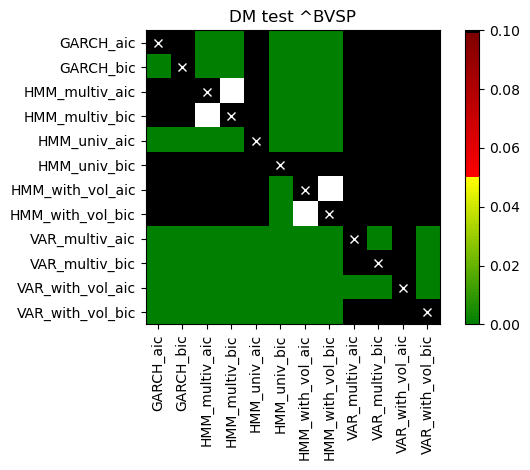

VALE3.SA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


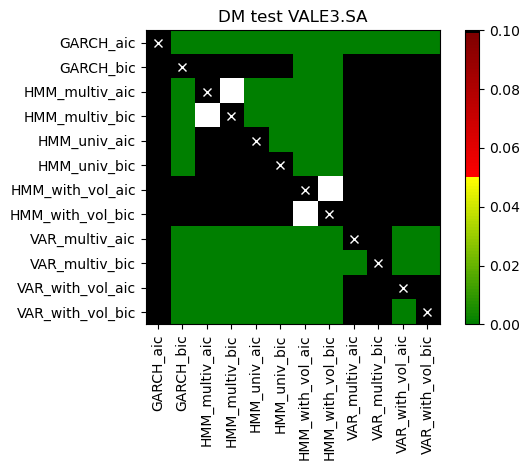

VALE


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


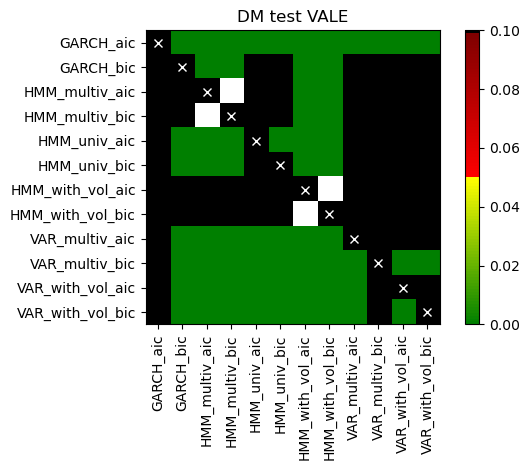

PETR3.SA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


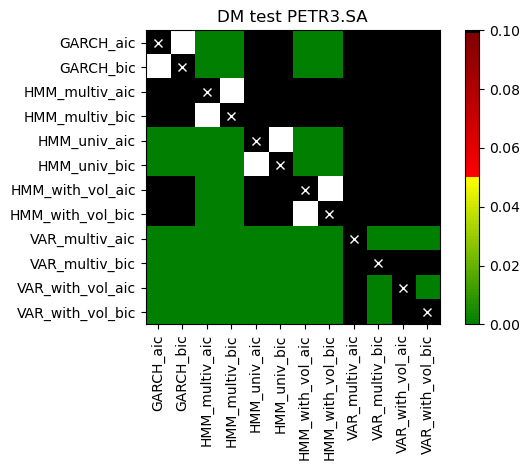

PBR


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


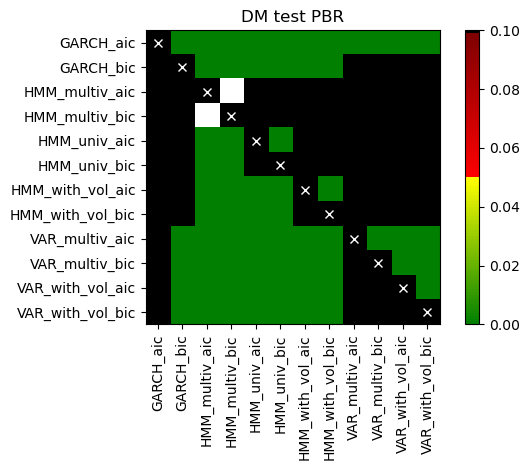

EMBR3.SA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


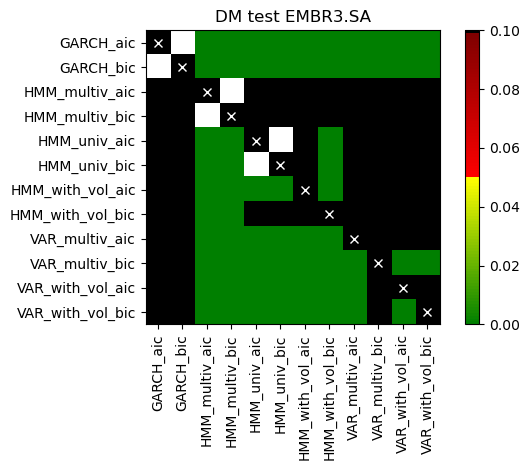

ERJ


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


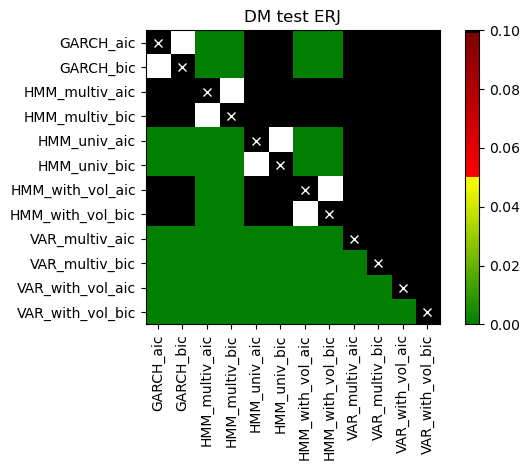

ABEV3.SA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


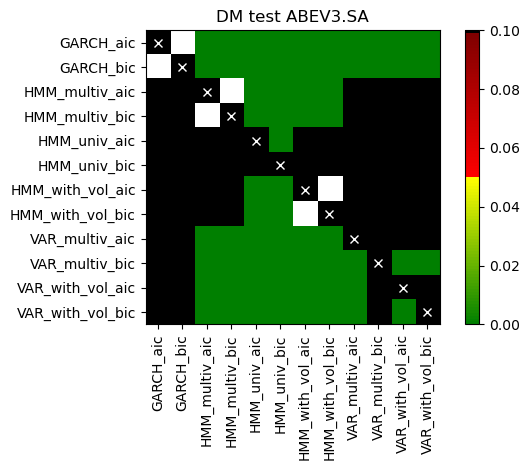

ABEV


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


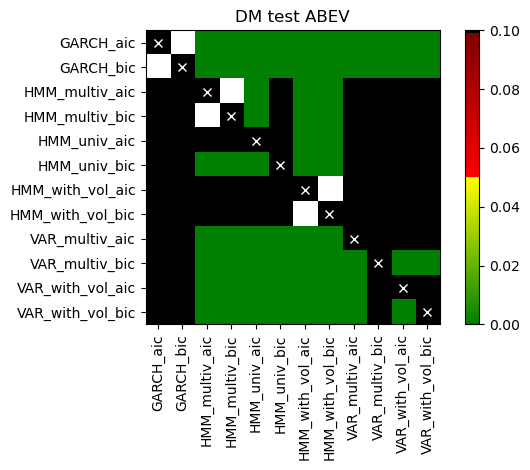

In [22]:
for stock in forecasts_by_stock.keys():
    print(stock)
    real_values=subset_of_columns(df_test, f"{stock}_log_rets")
    forecasts=delete_in_column_names(forecasts_by_stock[stock].fillna(0), f"__{stock}")   

    plot_multivariate_DM_test(real_price=real_values, 
                            forecasts=forecasts.fillna(0), 
                            title=f"DM test {stock}",
                            savefig=True,
                            path=dmroute)

In [23]:
best_models_by_stock={stock:None for stock in residuals_by_stock.keys()}

for stock, dataframe in residuals_by_stock.items():
    dataframe = delete_in_column_names(dataframe, f"__{stock}")
    metrics_df = pd.DataFrame(index=["mse", "meanabs", "medianabs"])

    for column in dataframe.columns:
        single_model=pd.DataFrame(dataframe[column])
        
        metrics_df.loc["mse", column] = (
            (single_model**2).mean().mean()
        )
        metrics_df.loc["meanabs", column] = (
            single_model.abs().mean().mean()
        )
        metrics_df.loc["medianabs", column] = (
            (single_model.abs()).median().median()
        )
    metrics_df = metrics_df * 100
        
    best_dict={}
    for criterion in metrics_df.index:
        best_dict[criterion] = metrics_df.iloc[metrics_df.index==criterion].idxmin(axis="columns").values[0]
        
    best_models_by_stock[stock]= (metrics_df, best_dict)

In [24]:
print(params["assetlist"][0])
best_models_by_stock[params["assetlist"][0]][1]

^BVSP


{'mse': 'VAR_multiv_aic',
 'meanabs': 'GARCH_aic',
 'medianabs': 'VAR_multiv_bic'}

In [25]:
best_models_by_stock[params["assetlist"][0]][0]

,GARCH_aic,GARCH_bic,HMM_multiv_aic,HMM_multiv_bic,HMM_univ_aic,HMM_univ_bic,HMM_with_vol_aic,HMM_with_vol_bic,VAR_multiv_aic,VAR_multiv_bic,VAR_with_vol_aic,VAR_with_vol_bic
mse,0.009101,0.009093,0.009815,0.009815,0.009527,0.009806,0.009817,0.009817,0.009078,0.009733,0.009493,0.009456
meanabs,0.778143,0.778538,0.806782,0.806782,0.795006,0.805278,0.806895,0.806895,0.790000,0.804165,0.805269,0.799667
medianabs,0.657612,0.661486,0.681399,0.681399,0.661279,0.674464,0.681381,0.681381,0.723734,0.629709,0.700265,0.717628
